### Sentiment Analysis - Version 02 (TFIDF-VADER)

+ Data source: MyVIB1, MyVIB2 in Android and iOS

Data Processing:
+ Vietnamese: correct typo by looking up the dictionary
+ Vietnamese: count the negative sentiment word in review sentence
+ Vietnamese to English: Google translate
+ English:    clean english text data (remove stopwords, etc.)

Feature engineer:
+ TF-IDF : get 1000 features
+ VADER  : get vader compound score
+ Negative Word: get potential mark of negative sentiment 


TRAIN:
+ Feature: TF-IDF, VADER, NEGATIVE_WORD | LABEL (RATING<4|NEGATIVE_WORD>0)




In [1]:
import json
import pandas as pd
import numpy as np

from tqdm import tqdm
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
import sys

import regex as re
from deep_translator import GoogleTranslator

from collections import Counter

import textacy.preprocessing.normalize as tprep
from textacy.preprocessing.remove import accents
import string

import nltk
from nltk.corpus import opinion_lexicon,wordnet,stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import os
from datetime import date
import datetime
import time
import shutil
import os

import enchant
dict_english = enchant.Dict("en_US")

#from TopicModeling import *
import pickle

# Android
from google_play_scraper import Sort, reviews, app, reviews_all

# iOS
from app_store_scraper import AppStore

In [5]:
# included code
import sys

sys.path.append('./mylib')
import global_materials
from load import *
from sentiment_process import *

stopwords = global_materials.stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nlt

In [6]:
# Parameter set
bank_array = ['tcb','tpb','bid','vcb','mb'] 

#### FOLDER STRUCTURE

In [7]:
today = date.today()
TRAIN_ROOT = './data/train'

if not os.path.exists("model"):
    os.mkdir("model")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists(TRAIN_ROOT):
    os.mkdir(TRAIN_ROOT)
if not os.path.exists(TRAIN_ROOT+"/translate_"+str(today)):
    os.mkdir(TRAIN_ROOT+"/translate_"+str(today))

#### DATA COLLECTION
**1) ANDROID**

In [9]:

rw_android_src_dict = {'vib1':['com.vn.vib.mobileapp','vi','vn'],
                       'vib2':['com.vib.myvib2','vi','vn'],
                       'tcb':['vn.com.techcombank.bb.app','vi','vn'],
                       'tpb':['com.tpb.mb.gprsandroid','vi','vn'],
                       'bid':['vn.com.bidv.ibank','vi','vn'],
                       'vcb':['com.VCB','vi','vn'],
                       'mb':['com.mbcorp','vi','vn']
                       }
#----------------------------------------------------------------------------------------------------------
# get Android review
column = ['reviewId','userName','userImage','content','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt','bankapp']
df_android_rw = pd.DataFrame(columns = column)

get_review_in = bank_array #rw_android_src_dict.keys()

for bank_name in get_review_in:
    Andrw_df = get_rwdata_android(rw_android_src_dict, bank_name, save_path=TRAIN_ROOT)   
    Andrw_df['bankapp'] = bank_name
    df_android_rw = pd.concat([df_android_rw, Andrw_df])
    time.sleep(30)
    
df_android_rw.reset_index(drop=True, inplace=True)
df_android_rw.to_csv(TRAIN_ROOT+'/1_AndRaw_'+str(today)+'_nbank.csv', index=False)

print(df_android_rw.shape)
df_android_rw.head(1)

#----------------------------------------------------------------------------------------------------------
df_android_rw['month'] = pd.DatetimeIndex(df_android_rw['at']).month
df_android_rw['year'] = pd.DatetimeIndex(df_android_rw['at']).year
df_android_rw['m_y'] = df_android_rw['month'].astype(str)+df_android_rw['year'].astype(str)

#JUST RAW
df_android_used = df_android_rw[['userName','content','at','m_y','score']]
df_android_used.rename(columns = {'userName':'username','content':'review','at':'date','score':'rating'}, inplace=True)

# Convert timetamps to string
df_android_used['date'] = df_android_used['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
print(df_android_used.shape)
df_android_used.head(1)


tcb: (18789, 10)
tpb: (30115, 10)
bid: (94, 10)
vcb: (39060, 10)
mb: (2085, 10)
(90143, 11)


C:\Users\nhan.ngothanh1\AppData\Local\Temp\ipykernel_640\3810009053.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_android_used.rename(columns = {'userName':'username','content':'review','at':'date','score':'rating'}, inplace=True)


(90143, 5)


C:\Users\nhan.ngothanh1\AppData\Local\Temp\ipykernel_640\3810009053.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_android_used['date'] = df_android_used['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))


,username,review,date,m_y,rating
0,Hoangkha Nguyen,Rát hây,2022-09-25 05:35:30,92022,5


**2) iOS**

In [10]:

rw_ios_src_dict = {'vib1':['MyVIB','vn','949371011'],
                   'vib2':['MyVIB 2.0','vn','1626624790'],
                   'tcb':['Techcombank Mobile','vn','1548623362'],
                   'tpb':['TPBank Mobile','vn','450464147'],
                   'bid':['SmartBanking','vn','1061867449'],
                   'vcb':['Vietcombank','vn','561433133'],
                   'mb':['BIZ MBBANK','vn','1424005630']
                  }

#----------------------------------------------------------------------------------------------------------
column = ['title','userName','isEdited','review','date','rating','developerResponse','bankapp']
df_ios_rw = pd.DataFrame(columns = column)

get_review_in = bank_array #rw_ios_src_dict.keys()

for bankapp in get_review_in:
    iosrw_df = get_rwdata_ios(rw_ios_src_dict, bankapp, save_path=TRAIN_ROOT)  
    iosrw_df['bankapp'] = bankapp
    df_ios_rw = pd.concat([df_ios_rw, iosrw_df])  
    time.sleep(30)
    
today = date.today()
df_ios_rw.reset_index(drop=True, inplace=True)
df_ios_rw.to_csv(TRAIN_ROOT+'/1_iOSRaw_'+str(today)+'_nbank.csv', index=False)

#----------------------------------------------------------------------------------------------------------
df_ios_rw['month'] = pd.DatetimeIndex(df_ios_rw['date']).month
df_ios_rw['year'] = pd.DatetimeIndex(df_ios_rw['date']).year
df_ios_rw['m_y'] = df_ios_rw['month'].astype(str)+df_ios_rw['year'].astype(str)

#JUST RAW
df_ios_used = df_ios_rw[['userName','review','date','m_y','rating']]
df_ios_used.rename(columns = {'userName':'username'}, inplace=True)

# Convert timetamps to string
df_ios_used['date'] = df_ios_used['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

# Note the latest datetime of review API download to file
file_name = TRAIN_ROOT+'/lastest_review_query.txt'
with open(file_name, 'w') as file:
    file.write(datetime.datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)"))   
    
with open(file_name, 'r') as file:
    lastest_review_query = datetime.datetime.strptime(file.read(), "%d-%b-%Y (%H:%M:%S.%f)")
    
lastest_review_query

2022-09-26 09:20:10,844 [INFO] Base - Initialised: AppStore('vn', 'techcombank-mobile', 1548623362)
2022-09-26 09:20:10,845 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/vn/app/techcombank-mobile/id1548623362
2022-09-26 09:20:16,491 [INFO] Base - [id:1548623362] Fetched 220 reviews (220 fetched in total)
2022-09-26 09:20:24,770 [INFO] Base - [id:1548623362] Fetched 500 reviews (500 fetched in total)
2022-09-26 09:20:30,220 [INFO] Base - [id:1548623362] Fetched 800 reviews (800 fetched in total)
2022-09-26 09:20:35,898 [INFO] Base - [id:1548623362] Fetched 1000 reviews (1000 fetched in total)
2022-09-26 09:20:42,390 [INFO] Base - [id:1548623362] Fetched 1260 reviews (1260 fetched in total)
2022-09-26 09:20:47,975 [INFO] Base - [id:1548623362] Fetched 1540 reviews (1540 fetched in total)
2022-09-26 09:20:54,703 [INFO] Base - [id:1548623362] Fetched 1800 reviews (1800 fetched in total)
2022-09-26 09:21:00,924 [INFO] Base - [id:1548623362] Fetched 2020 reviews (2020 fet

tcb: (7763, 7)


2022-09-26 09:23:24,410 [INFO] Base - Initialised: AppStore('vn', 'tpbank-mobile', 450464147)
2022-09-26 09:23:24,411 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/vn/app/tpbank-mobile/id450464147
2022-09-26 09:23:29,713 [INFO] Base - [id:450464147] Fetched 260 reviews (260 fetched in total)
2022-09-26 09:23:35,188 [INFO] Base - [id:450464147] Fetched 580 reviews (580 fetched in total)
2022-09-26 09:23:40,479 [INFO] Base - [id:450464147] Fetched 900 reviews (900 fetched in total)
2022-09-26 09:23:46,582 [INFO] Base - [id:450464147] Fetched 1200 reviews (1200 fetched in total)
2022-09-26 09:23:52,163 [INFO] Base - [id:450464147] Fetched 1540 reviews (1540 fetched in total)
2022-09-26 09:23:57,700 [INFO] Base - [id:450464147] Fetched 1860 reviews (1860 fetched in total)
2022-09-26 09:24:03,115 [INFO] Base - [id:450464147] Fetched 2040 reviews (2040 fetched in total)
2022-09-26 09:24:08,658 [INFO] Base - [id:450464147] Fetched 2300 reviews (2300 fetched in total)
2022-

tpb: (7553, 7)


2022-09-26 09:26:35,856 [INFO] Base - Initialised: AppStore('vn', 'smartbanking', 1061867449)
2022-09-26 09:26:35,856 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/vn/app/smartbanking/id1061867449
2022-09-26 09:26:41,389 [INFO] Base - [id:1061867449] Fetched 280 reviews (280 fetched in total)
2022-09-26 09:26:47,155 [INFO] Base - [id:1061867449] Fetched 480 reviews (480 fetched in total)
2022-09-26 09:26:52,625 [INFO] Base - [id:1061867449] Fetched 720 reviews (720 fetched in total)
2022-09-26 09:26:58,423 [INFO] Base - [id:1061867449] Fetched 1040 reviews (1040 fetched in total)
2022-09-26 09:27:04,124 [INFO] Base - [id:1061867449] Fetched 1260 reviews (1260 fetched in total)
2022-09-26 09:27:09,838 [INFO] Base - [id:1061867449] Fetched 1560 reviews (1560 fetched in total)
2022-09-26 09:27:15,315 [INFO] Base - [id:1061867449] Fetched 1800 reviews (1800 fetched in total)
2022-09-26 09:27:21,169 [INFO] Base - [id:1061867449] Fetched 2100 reviews (2100 fetched in tota

bid: (4235, 7)


2022-09-26 09:28:43,028 [INFO] Base - Initialised: AppStore('vn', 'vietcombank', 561433133)
2022-09-26 09:28:43,030 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/vn/app/vietcombank/id561433133
2022-09-26 09:28:48,292 [INFO] Base - [id:561433133] Fetched 160 reviews (160 fetched in total)
2022-09-26 09:28:53,789 [INFO] Base - [id:561433133] Fetched 440 reviews (440 fetched in total)
2022-09-26 09:28:59,399 [INFO] Base - [id:561433133] Fetched 780 reviews (780 fetched in total)
2022-09-26 09:29:05,034 [INFO] Base - [id:561433133] Fetched 1020 reviews (1020 fetched in total)
2022-09-26 09:29:11,358 [INFO] Base - [id:561433133] Fetched 1320 reviews (1320 fetched in total)
2022-09-26 09:29:17,111 [INFO] Base - [id:561433133] Fetched 1540 reviews (1540 fetched in total)
2022-09-26 09:29:22,940 [INFO] Base - [id:561433133] Fetched 1820 reviews (1820 fetched in total)
2022-09-26 09:29:28,397 [INFO] Base - [id:561433133] Fetched 2080 reviews (2080 fetched in total)
2022-09-2

vcb: (7649, 6)


2022-09-26 09:31:57,272 [INFO] Base - Initialised: AppStore('vn', 'biz-mbbank', 1424005630)
2022-09-26 09:31:57,272 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/vn/app/biz-mbbank/id1424005630
2022-09-26 09:32:02,279 [INFO] Base - [id:1424005630] Fetched 300 reviews (300 fetched in total)
2022-09-26 09:32:09,058 [INFO] Base - [id:1424005630] Fetched 600 reviews (600 fetched in total)
2022-09-26 09:32:12,796 [INFO] Base - [id:1424005630] Fetched 828 reviews (828 fetched in total)


mb: (828, 7)


C:\Users\nhan.ngothanh1\AppData\Local\Temp\ipykernel_640\2785085360.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ios_used.rename(columns = {'userName':'username'}, inplace=True)
C:\Users\nhan.ngothanh1\AppData\Local\Temp\ipykernel_640\2785085360.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ios_used['date'] = df_ios_used['date'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))


datetime.datetime(2022, 9, 26, 9, 32, 43, 241109)

**3) Combine Android and iOS data**

In [11]:
df_used = pd.concat([df_android_used, df_ios_used])
df_used['duplicate'] = df_used.duplicated(subset=['username', 'm_y', 'review'], keep='first')
print('BEFORE: df_used.shape = ',df_used.shape[0])
df_used = df_used[df_used['duplicate']==False] #remove duplicate
df_used.reset_index(inplace=True, drop=True)
print('AFTER DUPLICATE PROCESSING: df_used.shape = ',df_used.shape[0])
# process for date column
df_used['date'] = df_used['date'].apply(lambda x: ('20'+x) if (len(x)==17) else x ) # add '20' before datetime string for right format yyyy-mm-dd 
df_used['date'] = df_used['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df_used.to_csv(TRAIN_ROOT+'/2_dataApp_combine.csv',index=False,sep='\t')


BEFORE: df_used.shape =  118171
AFTER DUPLICATE PROCESSING: df_used.shape =  107538


#### Text Processing 
**1) Vietnamese - Typo correction**

In [12]:
# remove null review
df_used = df_used[~(df_used['review'].isnull()|df_used['review'].isna())]

# typo correction by looking up dict
df_used['review_adj'] = df_used['review'].apply(lambda x: review_vietnamese_adj(x.lower()))
df_used['ymdhms'] = pd.to_datetime(df_used['date']).dt.strftime("%Y_%m_%d_%H_%M_%S")
df_used.to_csv(TRAIN_ROOT+'/3_dataApp_typo_corrected_'+str(today)+'.csv',encoding='utf-16',index=False,sep='\t')

# Count Vietnamese negative and positive words in the sentence
df_used['negative_word'] = df_used['review_adj'].apply(lambda x: review_vietnamese_match_wordlist(x, global_materials.negative_word))
df_used['positive_word'] = df_used['review_adj'].apply(lambda x: review_vietnamese_match_wordlist(x, global_materials.positive_word))

#df_used = pd.read_csv('df_used_vn_correct_bf_trans.csv',index_col=False,sep='\t')
print(df_used.shape)
df_used.head(1)


(107537, 9)


,username,review,date,m_y,rating,duplicate,review_adj,ymdhms,negative_word
0,Hoangkha Nguyen,Rát hây,2022-09-25 05:35:30,92022,5,False,rát hây,2022_09_25_05_35_30,0


**2) Vietnamese to English translation**

In [13]:
# Run Google Translation
filenameF = TRAIN_ROOT+'/4_dataApp_EN_'+str(today)+'.csv'

response = False
cur_i = 0
#df_trans = pd.DataFrame()
if not os.path.exists(filenameF):
    while (response==False):
        cur_i, response = google_translate(df_used,TRAIN_ROOT+'/translate_'+str(today), cur_i, 1000)
        
    df_train = pd.DataFrame()
    for fl in os.listdir(TRAIN_ROOT+'/translate_'+str(today)): 
        df_temp = pd.read_csv(TRAIN_ROOT+'/translate_'+str(today)+'/'+fl, index_col=False, sep='\t')
        df_train = pd.concat([df_train,df_temp])
    print(df_train.shape)
    df_train.to_csv(filenameF, index=False, sep='\t')
    
else:
    print(f'{filenameF} is Existed! Please check if you want to retranslate.')
#del df_used

Content: out length:35537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: out length:537, in length: 107537
Content: 

In [4]:
# # Run Google Translation
# filenameF = TRAIN_ROOT+'/4_dataApp_EN_'+str(today)+'.csv'
# df_train = pd.DataFrame()
# for fl in os.listdir(TRAIN_ROOT+'/translate_2022-09-26'): 
#     df_temp = pd.read_csv(TRAIN_ROOT+'/translate_2022-09-26'+'/'+fl, index_col=False, sep='\t')
#     df_train = pd.concat([df_train,df_temp])
# print(df_train.shape)
# df_train.to_csv(filenameF, index=False, sep='\t')

(107537, 10)


**3) English - Clean text**

In [6]:
filenameF = TRAIN_ROOT+'/4_dataApp_EN_2022-09-27.csv'
df_train = pd.read_csv(filenameF, index_col=False, sep='\t')
df_train = df_train[~(df_train['review_adj'].isnull()|df_train['review'].isna())]

# Clean English 
df_train['positive_word'] = df_train['review_adj'].apply(lambda x: review_vietnamese_match_wordlist(x, global_materials.positive_word))
df_train['negative_word'] = df_train['review_adj'].apply(lambda x: review_vietnamese_match_wordlist(x, global_materials.negative_word))
df_train = review_english_clean(df_train)

#### EMBEDDING METHODS

**1) VADER**

In [15]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()
#sentiment.polarity_scores('I love VIB')

df_train['vader_pos']      = df_train['review_clean'].apply(lambda x: sentiment.polarity_scores(x)['pos'])
df_train['vader_neg']      = df_train['review_clean'].apply(lambda x: sentiment.polarity_scores(x)['neg'])
df_train['vader_neu']      = df_train['review_clean'].apply(lambda x: sentiment.polarity_scores(x)['neu'])
df_train['vader_compound'] = df_train['review_clean'].apply(lambda x: sentiment.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nhan.ngothanh1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# Labeling
df_train['label_rating']  = df_train['rating'].apply(lambda x: 1 if x<=3 else 0)

df_train['flag_posword']  = df_train['positive_word'].apply(lambda x: 1 if x>=1 else 0)
df_train['flag_negword']  = df_train['negative_word'].apply(lambda x: 1 if x>=1 else 0)

df_train['label_negword'] = np.where(df_train['flag_negword']>df_train['flag_posword'],1,0)
df_train['label_vader']   = df_train['vader_compound'].apply(lambda x: 1 if x<-0.05 else 0)

df_train['label_sum']     = df_train[['label_rating','label_negword','label_vader']].sum(axis=1)
df_train['label']         = df_train['label_sum'].apply(lambda x: 1 if x>=2 else 0)

print(df_train.shape)
df_train[['review','review_adj','review_en','review_clean','flag_negword','flag_posword','label_rating','label_negword','label_vader','label_sum','label']].to_csv(TRAIN_ROOT+'/6_dataApp_lable_check.csv', encoding='utf-16', sep='\t', index=False)

(90415, 23)


In [17]:
df_train.to_csv(TRAIN_ROOT+'/5_dataApp_EN_clean_vader.csv', index=False)
df_train.shape

(90415, 23)

In [8]:
# concat VIB and nbank data
df_train_vib = pd.read_csv(TRAIN_ROOT+'/5_dataApp_EN_clean_vader_vib.csv', index_col=False)
df_train_vib['bank_flag'] = 'vib'
#df_train_vib_test = df_train_vib[(df_train_vib.shape[0]-1000):df_train_vib.shape[0]]
df_train = pd.read_csv(TRAIN_ROOT+'/5_dataApp_EN_clean_vader.csv', index_col=False)
df_train['bank_flag'] = 'nbank'
df_train = pd.concat([df_train,df_train_vib]).reset_index(drop=True)
df_train.shape

(96829, 26)

In [9]:
#[Add for probability]
df_train['label_prob'] = df_train['label_sum']/3

In [10]:
df_train.columns.values

array(['username', 'review', 'date', 'm_y', 'rating', 'duplicate',
       'review_adj', 'ymdhms', 'negative_word', 'review_en',
       'positive_word', 'review_clean', 'review_empty', 'vader_pos',
       'vader_neg', 'vader_neu', 'vader_compound', 'label_rating',
       'flag_posword', 'flag_negword', 'label_negword', 'label_vader',
       'label_sum', 'label', 'bank_flag', 'label_negword_pre',
       'label_prob'], dtype=object)

In [11]:
df_train['bank_flag'].value_counts()

nbank    90415
vib       6414
Name: bank_flag, dtype: int64

#### 2. TF-IDF Vertorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = pickle.load(open('./model/TFIDF_VECTORIZER_app.pk','rb'))
col_list = [i.lstrip() for i in tfidf_vectorizer.get_feature_names_out()]
col_list = np.array(col_list)
df_tfidf = pd.DataFrame(data=tfidf_vectorizer.transform(df_train['review_clean'].values).toarray(), columns=col_list)    

#df_tfidf = pd.DataFrame(data=X.toarray(), columns = col_list)
df_tfidf['label_vader'] = df_train['label_vader'].values
df_tfidf['label_negword'] = df_train['label_negword'].values
#df_tfidf['flag_posword'] = df_train['flag_posword'].values
df_tfidf['bank_flag'] = df_train['bank_flag'].values
#df_tfidf = df_tfidf[(df_tfidf['vader_compound']<-0.05)|(df_tfidf['vader_compound']>0.05)]
#df_tfidf['vader_compound'] = df_tfidf['vader_compound'].apply(lambda x: 0 if x<-0.05 else 1 if x>0.05 else 0.5 )

df_tfidf['label'] = df_train['label_prob'].values
df_tfidf.head()


,able,accept,access,accord,account,account balance,account lock,account not,account number,account package,...,wrong,wrong not,wrong password,year,yesterday,yet,label_vader,label_negword,bank_flag,label
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,nbank,0.000000
1,0.0,0.0,0.0,0.0,0.210221,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,nbank,0.666667
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,nbank,0.333333
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,nbank,0.666667
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,nbank,0.666667


In [16]:
len(df_tfidf.columns.values)

1004

#### MODELING 
**0) Train Test dataset**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

FEA_COL = [col for col in df_tfidf.columns.values if col not in ['label', 'bank_flag']]
print(len(FEA_COL))

df_tfidf_b = df_tfidf[df_tfidf['bank_flag']=='nbank']
X = df_tfidf_b[FEA_COL].values
y = df_tfidf_b['label'].values
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

df_tfidf_b = df_tfidf[df_tfidf['bank_flag']=='vib']
X = df_tfidf_b[FEA_COL].values
y = df_tfidf_b['label'].values
X_train_vib, X_test_vib, y_train_vib, y_test_vib = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = np.vstack((X_train_nb,X_train_vib))#np.concatenate((X_train_nb,X_train_vib))
y_train = np.concatenate((y_train_nb,y_train_vib))
X_test = X_test_nb
y_test = y_test_nb

X = df_tfidf[FEA_COL].values
y = df_tfidf['label'].values
#X_test_vib
#y_test_vib

1002


In [47]:
np.unique(y_train)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [55]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 35393, 0.3333333333333333: 8432, 0.6666666666666666: 15125, 1.0: 18513}

In [56]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 8240, 0.3333333333333333: 1935, 0.6666666666666666: 3559, 1.0: 4349}

In [78]:
unique, counts = np.unique(y_test_vib, return_counts=True)
dict(zip(unique, counts))

{0.0: 609, 0.3333333333333333: 173, 0.6666666666666666: 222, 1.0: 279}

MLPRegression

In [68]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(100,50,1), \
                    solver='sgd', \
                    max_iter=100, \
                    activation='relu', \
                    random_state=1, \
                    learning_rate_init=0.0001,        
                    batch_size=X_train.shape[0], 
                    momentum=True).fit(X_train, y_train)

#regr.predict(X_test)

regr.score(X_test, y_test)

c:\Users\nhan.ngothanh1\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


-0.7563174845999636

In [66]:
y_pred = regr.predict(X_test)
y_pred

array([-0.16513126, -0.16513126, -0.16513126, ..., -0.16513126,
       -0.16513126, -0.16513126])

array([[<AxesSubplot:title={'center':'y_prob'}>]], dtype=object)

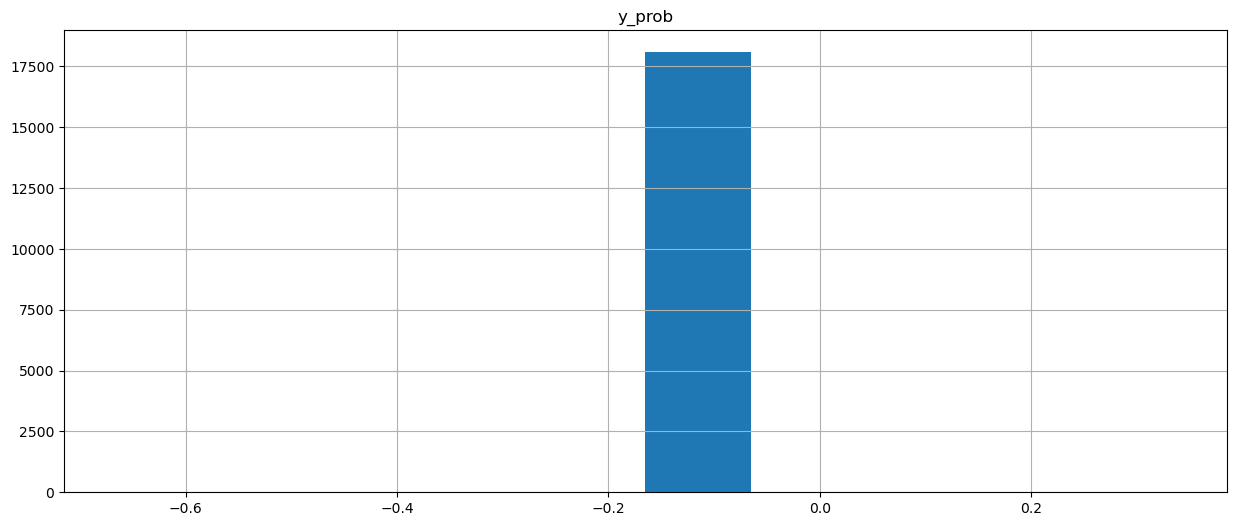

In [67]:
df_y_pred = pd.DataFrame(data=y_pred, columns=['y_prob'])
df_y_pred.hist(column=['y_prob'],bins=10, figsize=(15,6))

#### SGDRegressor

In [19]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(max_iter=1000, tol=1e-3, early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
model.fit(X_train, y_train)
pickle.dump(model, open("./model/SENTIMENT_MODEL_sgdr_prob.sav", "wb"))

y_pred = model.predict(X_test)
y_pred_adj = [1 if i>0.5 else 0  for i in y_pred]
y_test_adj =  [1 if i>0.5 else 0  for i in y_test]
print(classification_report(y_test_adj, y_pred_adj))
confusion_matrix(y_test_adj, y_pred_adj)

y_pred = model.predict(X_test_vib)
y_pred_adj = [1 if i>0.5 else 0  for i in y_pred]
y_test_vib_adj =  [1 if i>0.5 else 0  for i in y_test_vib]
print(classification_report(y_test_vib_adj, y_pred_adj))
confusion_matrix(y_test_vib_adj, y_pred_adj)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10175
           1       0.94      1.00      0.97      7908

    accuracy                           0.97     18083
   macro avg       0.97      0.97      0.97     18083
weighted avg       0.97      0.97      0.97     18083

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       782
           1       0.90      1.00      0.95       501

    accuracy                           0.96      1283
   macro avg       0.95      0.96      0.95      1283
weighted avg       0.96      0.96      0.96      1283



array([[726,  56],
       [  1, 500]], dtype=int64)

(array([387., 253.,  58.,   1.,  85., 201.,   0.,  26., 272.]),
 array([-0.08356   ,  0.04404211,  0.17164423,  0.29924634,  0.42684845,
         0.55445056,  0.68205267,  0.80965478,  0.93725689,  1.064859  ]),
 <BarContainer object of 9 artists>)

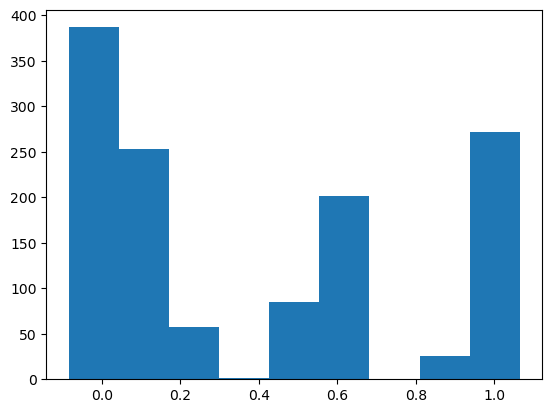

In [27]:
bin_arr = np.linspace(min(y_pred), max(y_pred), num=10)
plt.hist(y_pred, bins = bin_arr)

**1) Multinormial Naive Bayes**

In [9]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf = clf.fit(X_train, y_train)

# Result of model with tfidf

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

# #---------------------------------------------------
# # reuse old weight
# clf = pickle.load(open('./model/SENTIMENT_MODEL_mnb_app.sav','rb'))
# clf = clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))
# confusion_matrix(y_test, y_pred)
# #---------------------------------------------------

# Test with data of VIB
y_pred = clf.predict(X_test_vib)
print(classification_report(y_test_vib, y_pred))
confusion_matrix(y_test_vib, y_pred)

# Fit with full data and save model
clf = clf.fit(X, y)
pickle.dump(clf, open("./model/SENTIMENT_MODEL_mnb_app_nbank.sav", "wb"))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     10175
           1       0.89      0.99      0.94      7908

    accuracy                           0.94     18083
   macro avg       0.94      0.95      0.94     18083
weighted avg       0.95      0.94      0.94     18083

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       782
           1       0.81      0.99      0.89       501

    accuracy                           0.90      1283
   macro avg       0.90      0.92      0.90      1283
weighted avg       0.92      0.90      0.91      1283



Logistic Regression

In [69]:
from sklearn.metrics import f1_score
def logreg_select_threshold(X_train, y_train, X_test, y_test):
    
    train_f1_array = []
    test_f1_array = []
    threshold_array = []

    logreg_clf = LogisticRegression(solver='lbfgs', C=1, class_weight={0:1, 1:1})
    logreg_clf.fit(X_train, y_train)

    for thresh in np.arange(0,1,0.05):
        y_pred_train_reg = logreg_clf.predict_proba(X_train)[:,1]
        y_pred_train_thres = (y_pred_train_reg > thresh).astype(int)

        train_f1 = f1_score(y_train, y_pred_train_thres)

        y_pred_test_reg = logreg_clf.predict_proba(X_test)[:,1]
        y_pred_test_thres = (y_pred_test_reg > thresh).astype(int)

        test_f1 = f1_score(y_test, y_pred_test_thres)

        train_f1_array.append(train_f1)
        test_f1_array.append(test_f1)
        threshold_array.append(thresh)

    threshold_logreg = {'train_f1': train_f1_array, 'test_f1': test_f1_array,'threshold': threshold_array}
    threshold_logreg_df = pd.DataFrame.from_dict(threshold_logreg)

    threshold_logreg_df['threshold']=threshold_logreg_df['threshold'].apply(lambda x: float('{:.2f}'.format(x)))
    selected_threshold = threshold_logreg_df.loc[threshold_logreg_df[['test_f1']].idxmax(), 'threshold'].values[0]

    plot_df = threshold_logreg_df.melt('threshold', var_name='metrics', value_name='values')
    fig,ax = plt.subplots(figsize=(15,5))
    sb.pointplot(x='threshold',y='values',hue='metrics', data=plot_df, ax=ax)

    return logreg_clf, selected_threshold


In [70]:
import seaborn as sb
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)
# #clf.predict(X[:2, :])

# y_pred = clf.predict_proba(X_test)[:,1]
# print(y_pred)
# for thres in np.arange(0.1,1,0.1):
#     print("thres", thres)
#     y_pred = [1 if (i>thres) else 0 for i in y_pred ]
#     print(classification_report(y_test, y_pred))
#     confusion_matrix(y_test, y_pred)

# run LR 
logreg_clf, best_thres = logreg_select_threshold(X_train, y_train, X_test, y_test)
print(f'best_threshold = {best_thres}')
# predict with loading model
y_pred_test_reg = logreg_clf.predict_proba(X_test)[:,1]
y_pred_test_thres = (y_pred_test_reg > float(best_thres)).astype(int)

print(classification_report(y_test, y_pred_test_thres))



ValueError: Unknown label type: 'continuous'

In [24]:
best_thres

0.8

**2) Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8, min_samples_split = 10, min_samples_leaf=2, max_features='sqrt',random_state=42)
clf.fit(X_train, y_train)

# Result of model with tfidf
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

# #---------------------------------------------------
# # reuse old weight
# clf = pickle.load(open('./model/SENTIMENT_MODEL_rf_app.sav','rb'))
# clf = clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))
# confusion_matrix(y_test, y_pred)
# #---------------------------------------------------

# Test with data of VIB
y_pred = clf.predict(X_test_vib)
print(classification_report(y_test_vib, y_pred))
confusion_matrix(y_test_vib, y_pred)

# Fit with full data and save model
clf = clf.fit(X, y)
pickle.dump(clf, open("./model/SENTIMENT_MODEL_rf_app_nbank.sav", "wb"))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10063
           1       0.93      0.91      0.92      8020

    accuracy                           0.93     18083
   macro avg       0.93      0.93      0.93     18083
weighted avg       0.93      0.93      0.93     18083

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       781
           1       0.88      0.92      0.90       502

    accuracy                           0.92      1283
   macro avg       0.91      0.92      0.92      1283
weighted avg       0.92      0.92      0.92      1283



**3) SVC**

In [41]:
from sklearn.svm import SVC

clf = SVC(C=1, gamma=1, random_state=42)
clf.fit(X_train, y_train)

# Result of model with tfidf
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

# #---------------------------------------------------
# # reuse old weight
# clf = pickle.load(open('./model/SENTIMENT_MODEL_svc_app.sav','rb'))
# clf = clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))
# confusion_matrix(y_test, y_pred)
# #---------------------------------------------------

# Test with data of VIB
y_pred = clf.predict(X_test_vib)
print(classification_report(y_test_vib, y_pred))
confusion_matrix(y_test_vib, y_pred)

# Fit with full data and save model
clf = clf.fit(X, y)
pickle.dump(clf, open("./model/SENTIMENT_MODEL_svc_app_nbank.sav", "wb"))


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10063
           1       0.95      0.99      0.97      8020

    accuracy                           0.97     18083
   macro avg       0.97      0.98      0.97     18083
weighted avg       0.97      0.97      0.97     18083

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       781
           1       0.89      1.00      0.94       502

    accuracy                           0.95      1283
   macro avg       0.95      0.96      0.95      1283
weighted avg       0.96      0.95      0.95      1283



#### END ------------------------------------------------------------------------------------------------

#### PREDICTION 

In [ ]:
# Load REVIEW OF VIB and CHECK SENTIMENT
today = date.today()
column = ['reviewId','userName','userImage','content','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt','bankapp']
df_android_rw_pred = pd.DataFrame(columns = column)

for bank_name in ['vib1','vib2']:
    Andrw_df = get_rwdata_android(rw_android_src_dict, bank_name)   
    Andrw_df['bankapp'] = bank_name
    df_android_rw_pred = pd.concat([df_android_rw_pred, Andrw_df])
    time.sleep(30)
    
df_android_rw_pred.reset_index(drop=True, inplace=True)

reviews = df_android_rw_pred['content'].values

vib1: (4676, 10)
vib2: (1673, 10)


In [ ]:
reviews = df_android_rw_pred['content'].values
reviews = reviews[100:130] 

In [ ]:
reviews = ['Tôi thấy app của VIB cũng được. Xài cũng ok, nói chung ổn.',
           'dịch vụ chán, lỗi hoài',
           'cũng tạm ah, hôm được hôm không',
           'có cải thiện đó, chạy mượt hơn',
           'hài lòng với dịch vụ ở đây',
           'không thấy gì để chê với phí của vib',
           'tệ quá trời',
           'nhân viên chậm lắm',
           'hỗ trợ lâu không hài lòng',
           'càng nhiều kỷ niệm thì chia tay càng đau đớn',
           'tiếc cho họ nhìn mặt có nét phu thê quá trời',
           'tao còn mới thấy page nào đó bê cả câu bà của chúng tôi luôn cơ đấy',
           'chúng đã sai khi năm xưa mỉa mai chị đấy',
           'hóa ra năm xưa em đã trách lầm chị rồi',
           'bỏ tiền tỷ đầu tư này nọ xong giờ làm xấu mặt']

#reviews = ['hỗ trợ lâu không hài lòng']

df_pred = pd.DataFrame(data=reviews, columns=['review'])
# Vietnamese processing
df_pred['review_adj'] = df_pred['review'].apply(lambda x: review_vietnamese_adj(x).lower())

df_pred['negative_word'] = df_pred['review_adj'].apply(lambda x: review_vietnamese_match_negative_word(x))
df_pred['label_negword'] = df_pred['negative_word'].apply(lambda x: 1 if x>0 else 0)

# English translation
df_pred['review_en'] = df_pred['review_adj'].apply(lambda x: GoogleTranslator(source = 'vi', target = 'en').translate(x))
if 'username' not in df_pred.columns.values:
    df_pred['username'] = np.zeros(df_pred.shape[0])
    
df_pred = review_english_clean(df_pred)


# # English text clean
# df_pred['rw_english_norm'] = df_pred['review_en'].apply(lambda x: normalize(x))
# df_pred['review_clean'] = df_pred['rw_english_norm'].apply(lambda x: clean_text(x))

# if (len(message) == 0):
#     print('Message is Empty after processing. Can not predict sentiment :)')
#     sys.exit()
df_pred['vader_compound'] = df_pred['review_clean'].apply(lambda x: sentiment.polarity_scores(x)['compound'])
#df_pred['vader_compound'] = df_pred['vader_compound'].apply(lambda x: 0 if x<-0.05 else 1 if x>0.05 else 0.5 )
df_pred['vader_compound'] = df_pred['vader_compound'].apply(lambda x: 0 if x<0.05 else 1)

tfidf_vectorizer = pickle.load(open('./trained_model/TFIDF_VECTORIZER_app.pk','rb'))
#tfidf_vectorizer.get_feature_names_out()

df_tfidfx = pd.DataFrame(data=tfidf_vectorizer.transform(df_pred['review_clean'].values).toarray(), columns=col_list)
df_tfidfx['vader_compound'] = df_pred['vader_compound'].values
df_tfidfx['label_negword'] = df_pred['label_negword'].values
#df_pred = pd.concat([df_pred, df_tfidfx],axis=1,ignore_index=True)

# Load model
sentiment_MODEL = pickle.load(open('./trained_model/SENTIMENT_MODEL_TFIDF_app.sav','rb'))

y_pred = sentiment_MODEL.predict(df_tfidfx[FEA_COL].values)
df_pred['sentiment'] = y_pred
df_pred[['review','review_en','review_clean','vader_compound','sentiment']]
# check MODEL Trained with [TF-IDF, VADER_COMPOUND] and VADER MODEL --> MIX RESULT
# RESULT: NOT BETTER

# df_pred['tfidf_sentiment'] = y_pred

# df_pred['vader_sentiment'] = df_pred['vader_compound'].apply(lambda x: 0 if ((x-1)<-0.05) else 1)
# df_pred['sentiment_mix'] = np.where(df_pred['vader_sentiment'] == 0, 0, df_pred['tfidf_sentiment']) 
# df_pred[['review_en','review_clean','vader_compound','tfidf_sentiment','vader_sentiment','sentiment_mix']]

# Result of model with mix model


# print(df_pred)
# sys.exit()

Tôi thấy app của VIB cũng được Xài cũng okay nói chung ổn
dịch vụ chán lỗi hoài
cũng tạm ạ hôm được hôm không
có cải thiện đó chạy mượt hơn
hài lòng với dịch vụ ở đây
không thấy gì để chê với phí của vib
tệ quá trời
nhân viên chậm lắm
hỗ trợ lâu không hài lòng
càng nhiều kỷ niệm thì chia tay càng đau đớn
tiếc cho họ nhìn mặt có nét phu thê quá trời
tao còn mới thấy page nào đó bê cả câu bà của chúng tôi luôn cơ đấy
chúng đã sai khi năm xưa mỉa mai chị đấy
hóa ra năm xưa em đã trách lầm chị rồi
bỏ tiền tỷ đầu tư này nọ xong giờ làm xấu mặt
0      I think vib's app is also okay to use in general
1                                     service is boring
2                                          Good day too
3             There is an improvement, it runs smoother
4                       Satisfied with the service here
5     I don't see anything to complain about with vi...
6                                                so bad
7                                       very slow staff
8      

,review,review_en,review_clean,vader_compound,sentiment
0,"Tôi thấy app của VIB cũng được. Xài cũng ok, n...",I think vib's app is also okay to use in general,think okay use general,1,0
1,"dịch vụ chán, lỗi hoài",service is boring,service boring,0,1
2,"cũng tạm ah, hôm được hôm không",Good day too,good day,1,1
3,"có cải thiện đó, chạy mượt hơn","There is an improvement, it runs smoother",improvement run smoother,1,0
4,hài lòng với dịch vụ ở đây,Satisfied with the service here,satisfied service,1,0
5,không thấy gì để chê với phí của vib,I don't see anything to complain about with vi...,do not see anything complain fee,1,1
6,tệ quá trời,so bad,bad,0,1
7,nhân viên chậm lắm,very slow staff,slow staff,0,1
8,hỗ trợ lâu không hài lòng,unsatisfied long support,unsatisfied long support,0,1
9,càng nhiều kỷ niệm thì chia tay càng đau đớn,"The more memories, the more painful parting is",memory painful part,0,1


In [ ]:
df_pred.to_csv('CURRENT_REVIEW_FILE.csv', index=False, sep='\t')

In [ ]:
df_pred[['review','review_en','review_clean','vader_compound','sentiment']]

,review,review_en,review_clean,vader_compound,sentiment
0,"Tôi thấy app của VIB cũng được. Xài cũng ok, n...",I see vib's app is also ok to use in general,see use general,0,1
1,"dịch vụ chán, lỗi hoài",boring service forever,bore service forever,0,0
2,"cũng tạm ah, hôm được hôm không",Good day too,good day,1,1
3,"có cải thiện đó, chạy mượt hơn","There is an improvement, it runs smoother",improvement run smoother,1,1
4,hài lòng với dịch vụ ở đây,Satisfied with the service here,satisfied service,1,1
5,không thấy gì để chê với phí của vib,I don't see anything to complain about with vi...,do not see anything complain fee,1,0
6,tệ quá trời,so bad,bad,0,0
7,nhân viên chậm lắm,very slow staff,slow staff,0,0
8,hỗ trợ lâu không hài lòng,unsatisfied long support,unsatisfied long support,0,0
9,càng nhiều kỷ niệm thì chia tay càng đau đớn,"The more memories, the more painful parting is",memory painful part,0,0


In [ ]:
avg_sentiment_score = df_pred['sentiment'].sum()/df_pred.shape[0]
avg_sentiment_score

0.3333333333333333

##### END SENTIMENT PREDICTION
####################################################################################